# Fitting distribution of workplace size

This is an exercise on fitting real, in this case the distribution of company sizes in Denmark (in terms of FTE workers). This distribution was used in relation to Covid-19 modelling, but is in itself interresting.

You only need to consider the first two columns (size and frequency), as the rest is just derived from there.

NOTE: When extracting data from Statistics Denmark (DK: Danmarks Statistik), bins with less than 5 entries are by law not allowed to be revealed (to protect from ability to single out persons/companies), and are shown as NaN (Not a Number).

### References
Data from Statistics Denmark (contact: Laust Hvas Mortensen)

### Authors
Troels C. Petersen (NBI, petersen@nbi.dk)

### Date
29-11-2022 (latest update)

***

In [242]:
from __future__ import division, print_function

import sys
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from iminuit import Minuit
from scipy import stats
import pandas as pd
from scipy import interpolate

sys.path.append('C:\\Users\\Simon\\PycharmProjects\\Projects\\Projects\\AppStat2022\\External_Functions')
from ExternalFunctions import UnbinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax

In [243]:
save_plots = False   # For now, don't save plots (once you trust your code, switch on)
verbose = True       # For now, print a lot of output (once you trust your code, switch off)
Nverbose = 10        # But only print a lot for the first 10 random numbers
plt.style.use('seaborn')

C:\Users\Simon\AppData\Local\Temp\ipykernel_4696\900465625.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Load data

In [244]:
data_test = pd.read_csv("TableData_Denmark2020.txt", header=0, sep=' ', index_col=0)

print(data_test.head(10))
print("...")
print(data_test.tail(10))

# Two 1D arrays:
Nworkers = np.arange(1, 200)
Ncompanies = data_test["Frequency"].iloc[1:200].values  # "values" yields numpy arrays, while nothing gives a Pandas series

eNcompanies = np.sqrt(Ncompanies)         # assuming poisson distributed errors

minPlot = 1
maxPlot = 100


        Frequency  Percent  Cumulative  Frequency.1  Cumulative.1  Percent.1
ANTNOV                                                                      
0         20696.0     9.29       20696         9.29           NaN        NaN
1         52418.0    23.52       73114        32.80           NaN        NaN
2         27431.0    12.31      100545        45.11           NaN        NaN
3         17242.0     7.74      117787        52.84           NaN        NaN
4         13090.0     5.87      130877        58.72           NaN        NaN
5         10325.0     4.63      141202        63.35           NaN        NaN
6          8465.0     3.80      149667        67.15           NaN        NaN
7          6891.0     3.09      156558        70.24           NaN        NaN
8          5841.0     2.62      162399        72.86           NaN        NaN
9          4816.0     2.16      167215        75.02           NaN        NaN
...
        Frequency  Percent  Cumulative  Frequency.1  Cumulative.1  Perce

### Plotting the size distribution of companies

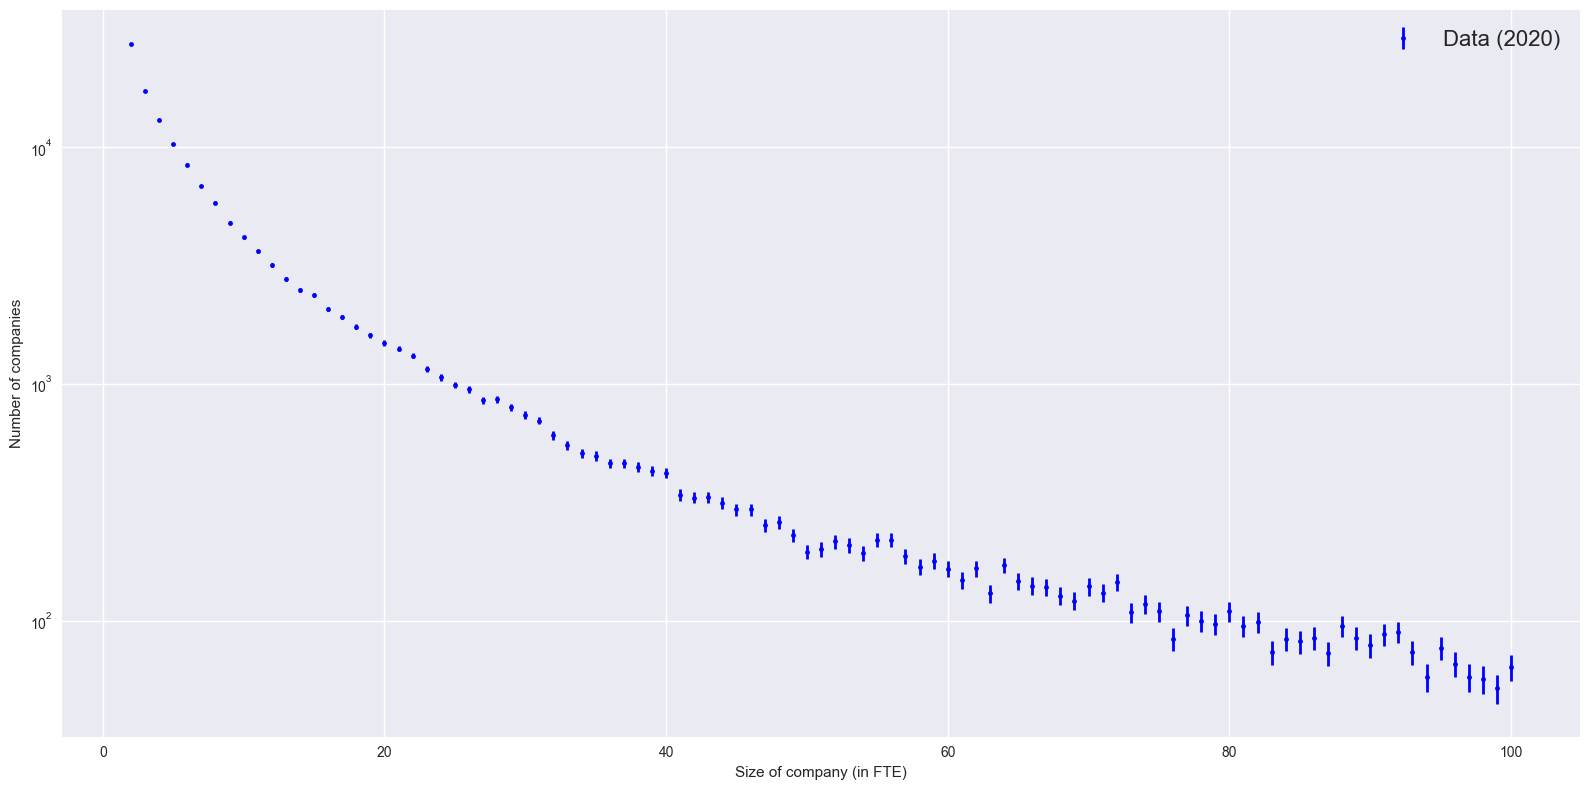

In [245]:
# Number of companies with a given size as a function of size:
fig_Ncompanies, ax_Ncompanies = plt.subplots(figsize=(16, 8))
ax_Ncompanies.set(xlabel="Size of company (in FTE)", ylabel="Number of companies", title="")
ax_Ncompanies.errorbar(Nworkers[minPlot:maxPlot], Ncompanies[minPlot:maxPlot], yerr=eNcompanies[minPlot:maxPlot], fmt='.', linewidth=2,
                  label='Data (2020)', color='blue')
ax_Ncompanies.legend(fontsize=16) #loc=(0.05, 0.75))

plt.yscale('log')
plt.tight_layout()
plt.show(block=False)

if (save_plots):
    plt.savefig("fig_DistNcompanies.pdf")

## Models

What is the best model for this distribution? Try the below models, and make better alternatives yourself.

In [246]:
# Power Law model:
def func_PowerLaw(x, N, alpha):
    x = x.astype('float')
    return N * x ** (-alpha)

func_PowerLaw_vec = np.vectorize(func_PowerLaw)

In [247]:
# Exponential model:
def func_Exponential(x, N, alpha):
    return N * np.exp(-alpha * x)

func_Exponential_vec = np.vectorize(func_Exponential)

### Fit to data with Power Law


  ------------------------------------  Fitting Stage  --------------------------------------- 

Fit value (exp): N = 89687.68905 +/- 424.03597
Fit value (exp): alpha = 1.45003 +/- 0.00204
  Model fit:  Prob(Chi2=6644.7, Ndof=197) = 0.00000
Fit value (exp): N = 20800.78478 +/- 145.98852
Fit value (exp): alpha = 0.13385 +/- 0.00072
  Model fit:  Prob(Chi2=18797.5, Ndof=197) = 0.00000


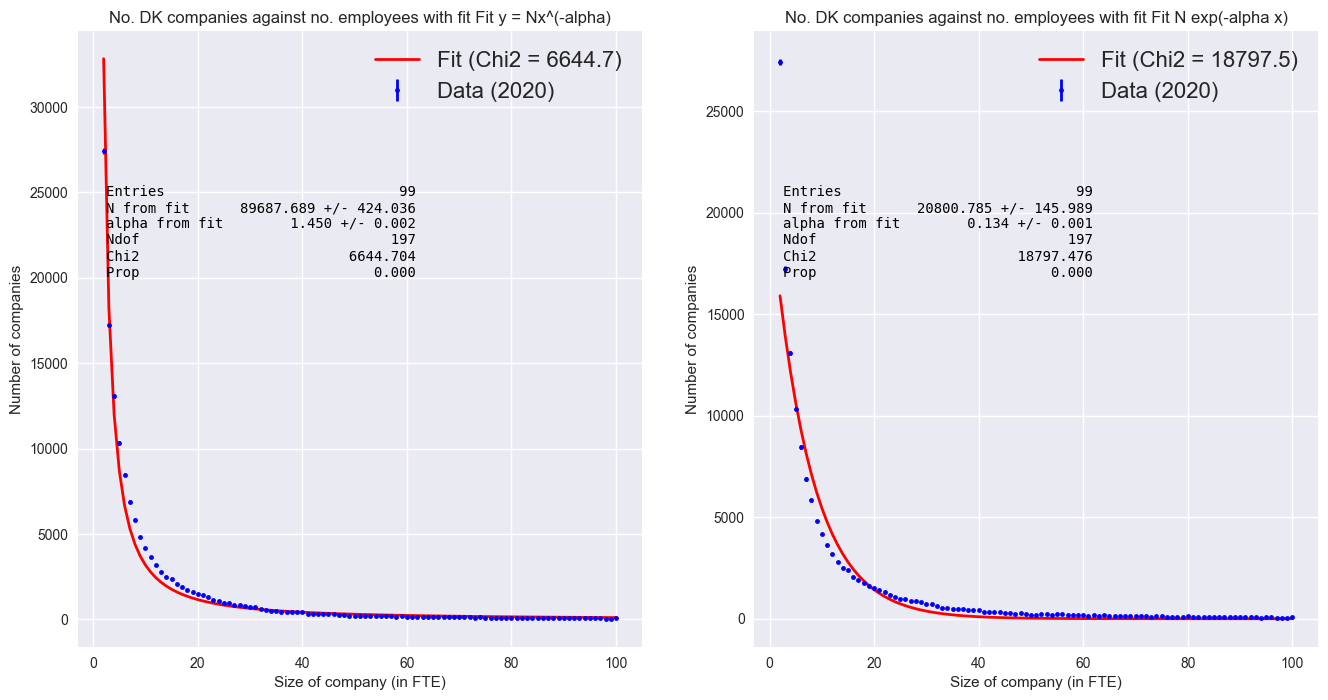

In [248]:
print("\n  ------------------------------------  Fitting Stage  --------------------------------------- \n")

minFit = 1
maxFit = 100

# Plot data points again
fig_fit, ax_fit = plt.subplots(nrows = 1, ncols = 2, figsize=(16, 8))
ax_fit = ax_fit.flatten()
 
fit_func_list = [func_PowerLaw, func_Exponential]
names = ['Fit y = Nx^(-alpha)','Fit N exp(-alpha x)']

for i, func in enumerate(fit_func_list):

    ax_fit[i].errorbar(Nworkers[minPlot:maxPlot], Ncompanies[minPlot:maxPlot], yerr=eNcompanies[minPlot:maxPlot], fmt='.', linewidth=2,
                    color="blue", label='Data (2020)')
    ax_fit[i].set(xlabel="Size of company (in FTE)", ylabel="Number of companies", 
    title=f'No. DK companies against no. employees with fit {names[i]}')

# Power Law fit:
# --------------
    if 0:
        def ChiSquarePowerLaw(N, alpha):
            Ncompanies_est = func_PowerLaw(Nworkers[minFit:maxFit], N, alpha)
            chi2 = np.sum(((Ncompanies[minFit:maxFit] - Ncompanies_est) / eNcompanies[minFit:maxFit]) ** 2)
            return chi2

    chi2_object = Chi2Regression(func, Nworkers[minFit:maxFit], Ncompanies[minFit:maxFit], eNcompanies[minFit:maxFit])

    minuit = Minuit(chi2_object, N=50000.0, alpha=2.0)
    minuit.errordef = 1.0   # Chi2 fit
    minuit.migrad();
    if (not minuit.fmin.is_valid):
        print("  WARNING: The ChiSquare fit DID NOT converge!!! ")

    for name in minuit.parameters:
        print("Fit value (exp): {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
    chi2 = minuit.fmin.fval
    Ndof = len(Ncompanies) - len(minuit.values[:])
    Prob = stats.chi2.sf(chi2, Ndof)
    print(f"  Model fit:  Prob(Chi2={chi2:6.1f}, Ndof={Ndof:3d}) = {Prob:7.5f}")

    N_fit, alpha_fit = minuit.values[:]
    eN_fit, ealpha_fit = minuit.errors[:]

    ax_fit[i].plot(Nworkers[minFit:maxFit], func(Nworkers[minFit:maxFit], N_fit, alpha_fit), 'red', linewidth=2.0,
                label=f'Fit (Chi2 = {chi2:6.1f})')

    d = {'Entries': len(Ncompanies[minFit:maxFit]), 'N from fit': [minuit.values['N'], minuit.errors['N']],
        'alpha from fit': [minuit.values['alpha'], minuit.errors['alpha']], 'Ndof': Ndof, 'Chi2': chi2, 'Prop': Prob}
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.05, 0.75, text, ax_fit[i], fontsize=10)
    ax_fit[i].legend(fontsize=16);

In [249]:
def power_exp(x, N1, N2, alpha, beta):
    return N1 * x ** (-alpha) + N2 * np.exp(-x * beta)

In [250]:
def exp_exp(x, N1, N2, alpha, beta):
    return N1 * np.exp(-alpha * x) + N2 * np.exp(- beta * x)

In [251]:
def power_sum(x, N1, N2, alpha, beta):
    return N1 * x ** (-alpha) + N2 * x ** (-beta)

In [252]:
def exp_squared(x, N1, N2, alpha, beta):
    return N1 * np.exp  (- alpha * np.power(x, 2)) + N2 * np.exp  (-beta * x)


  ------------------------------------  Fitting Stage  --------------------------------------- 

Actual no. companies with 101-150 employess:  1792.0  ± 42.33202097703345
Est no. companies for names0:  2619.654601127985
Actual no. companies with 101-150 employess:  1792.0  ± 42.33202097703345
Est no. companies for names1:  337.7865609723843
Actual no. companies with 101-150 employess:  1792.0  ± 42.33202097703345
Est no. companies for names2:  4047.9276664550007
Actual no. companies with 101-150 employess:  1792.0  ± 42.33202097703345
Est no. companies for names3:  67.03195632114503


c:\Users\Simon\PycharmProjects\Projects\Projects\AppStat2022\Week3\CompanySize\../../External_Functions\ExternalFunctions.py:121: RuntimeWarning: overflow encountered in square
  chi2 = np.sum(self.weights*(self.y - f)**2/self.sy**2)
C:\Users\Simon\AppData\Local\Temp\ipykernel_4696\386279763.py:2: RuntimeWarning: overflow encountered in exp
  return N1 * np.exp  (- alpha * np.power(x, 2)) + N2 * np.exp  (-beta * x)


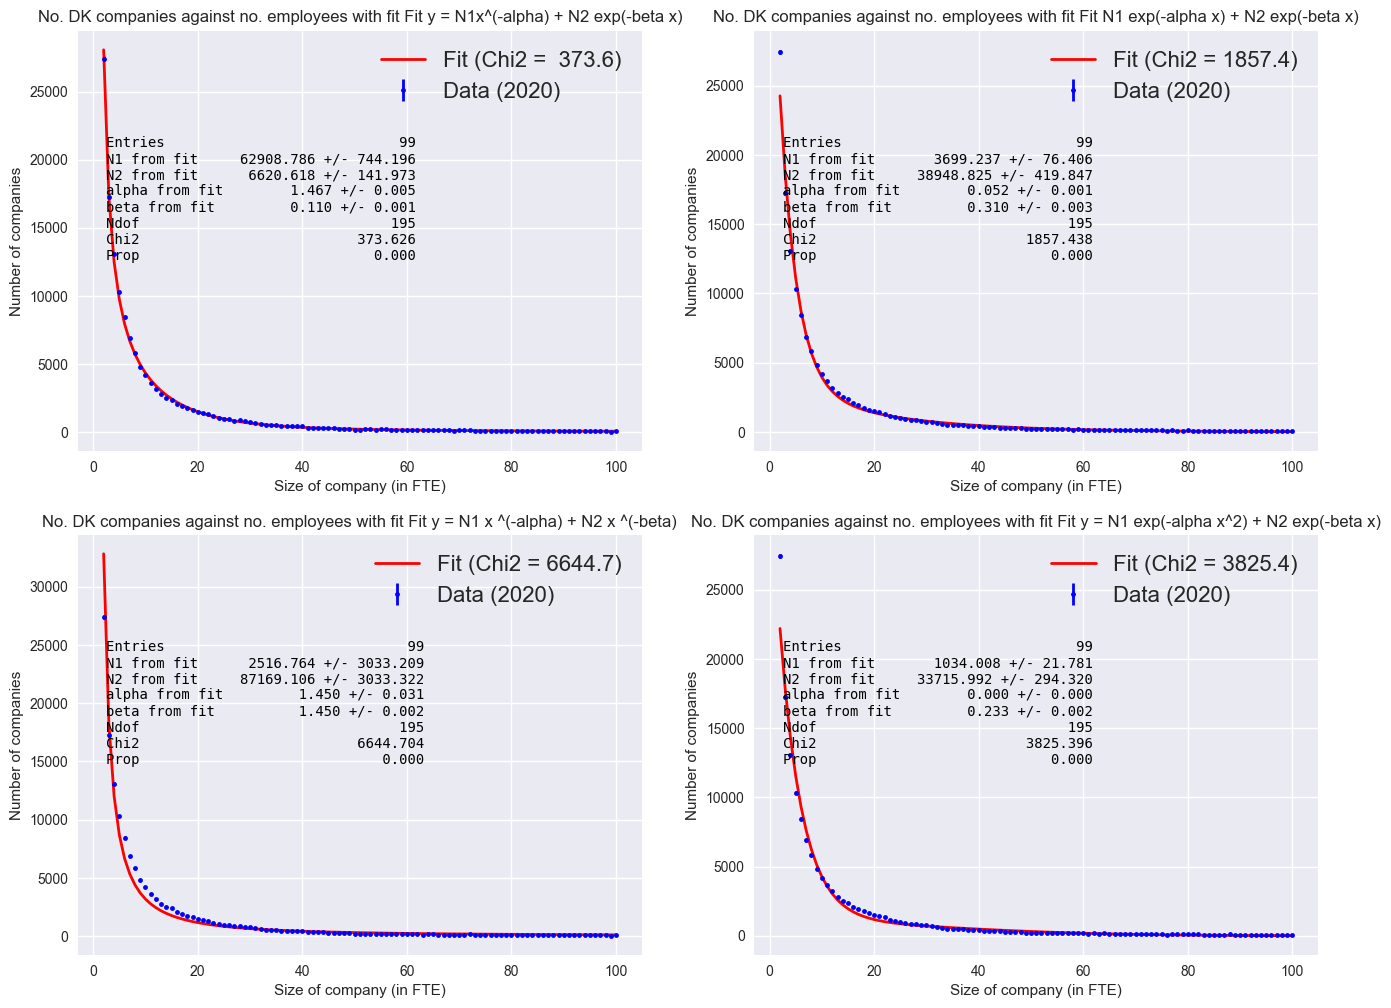

In [253]:
print("\n  ------------------------------------  Fitting Stage  --------------------------------------- \n")

minFit = 1
maxFit = 100

# Plot data points again
fig_fit, ax_fit = plt.subplots(nrows = 2, ncols = 2, figsize=(16, 12))
ax_fit = ax_fit.flatten()
 
fit_func_list = [power_exp, exp_exp, power_sum, exp_squared]
names = ['Fit y = N1x^(-alpha) + N2 exp(-beta x)','Fit N1 exp(-alpha x) + N2 exp(-beta x)',
        'Fit y = N1 x ^(-alpha) + N2 x ^(-beta)', 'Fit y = N1 exp(-alpha x^2) + N2 exp(-beta x)']

for i, func in enumerate(fit_func_list):

    ax_fit[i].errorbar(Nworkers[minPlot:maxPlot], Ncompanies[minPlot:maxPlot], yerr=eNcompanies[minPlot:maxPlot], fmt='.', linewidth=2,
                    color="blue", label='Data (2020)')
    ax_fit[i].set(xlabel="Size of company (in FTE)", ylabel="Number of companies", 
    title=f'No. DK companies against no. employees with fit {names[i]}')

# Power Law fit:
# --------------
    if 0:
        def ChiSquarePowerLaw(N, alpha):
            Ncompanies_est = func_PowerLaw(Nworkers[minFit:maxFit], N, alpha)
            chi2 = np.sum(((Ncompanies[minFit:maxFit] - Ncompanies_est) / eNcompanies[minFit:maxFit]) ** 2)
            return chi2

    chi2_object = Chi2Regression(func, Nworkers[minFit:maxFit], Ncompanies[minFit:maxFit], eNcompanies[minFit:maxFit])

    minuit = Minuit(chi2_object, N1=20000.0, N2 = 30000.0, alpha=2.0, beta = 3.0)
    minuit.errordef = 1.0   # Chi2 fit
    minuit.migrad();
    if (not minuit.fmin.is_valid): 
        print("  WARNING: The ChiSquare fit DID NOT converge!!! ")

    for name in minuit.parameters:
        pass
    #    print("Fit value (exp): {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
    chi2 = minuit.fmin.fval
    Ndof = len(Ncompanies) - len(minuit.values[:])
    Prob = stats.chi2.sf(chi2, Ndof)
    #print(f"  Model fit:  Prob(Chi2={chi2:6.1f}, Ndof={Ndof:3d}) = {Prob:7.5f}")

    N1_fit, N2_fit, alpha_fit, beta_fit = minuit.values[:]
    eN1_fit, eN2_fit, ealpha_fit, ebeta_fit = minuit.errors[:]

    ax_fit[i].plot(Nworkers[minFit:maxFit], func(Nworkers[minFit:maxFit], N1_fit, N2_fit, alpha_fit, beta_fit), 
                'red', linewidth=2.0, label=f'Fit (Chi2 = {chi2:6.1f})')

    d = {'Entries': len(Ncompanies[minFit:maxFit]), 'N1 from fit': [minuit.values['N1'], minuit.errors['N1']],
        'N2 from fit': [minuit.values['N2'], minuit.errors['N2']], 
        'alpha from fit': [minuit.values['alpha'], minuit.errors['alpha']], 
        'beta from fit': [minuit.values['beta'], minuit.errors['beta']],'Ndof': Ndof, 'Chi2': chi2, 'Prop': Prob}
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.05, 0.75, text, ax_fit[i], fontsize=10)
    ax_fit[i].legend(fontsize=16);

    # estimate no. of companies with 101-150 employees
    err = np.sqrt(np.sum(eNcompanies[101:150] ** 2))
    print('Actual no. companies with 101-150 employess: ', np.sum(Ncompanies[101:150]), " \u00B1", err)
    value_est = np.sum(func(Nworkers[101:150], N1_fit, N2_fit, alpha_fit, beta_fit))
    
    print(f'Est no. companies for names{i}: ', value_est )



In [254]:
def pol1(x, N1, N2, N3, N4, N5, alpha, beta):
    return power_exp(x, N1, N2, alpha, beta) + N3 * x**6 + N4 * x**7 + N5 * x**8


  ------------------------------------  Fitting Stage  --------------------------------------- 

Actual no. companies with 101-150 employess:  1792.0  ± 42.33202097703345
Est no. companies for names0:  4080.6104294148604


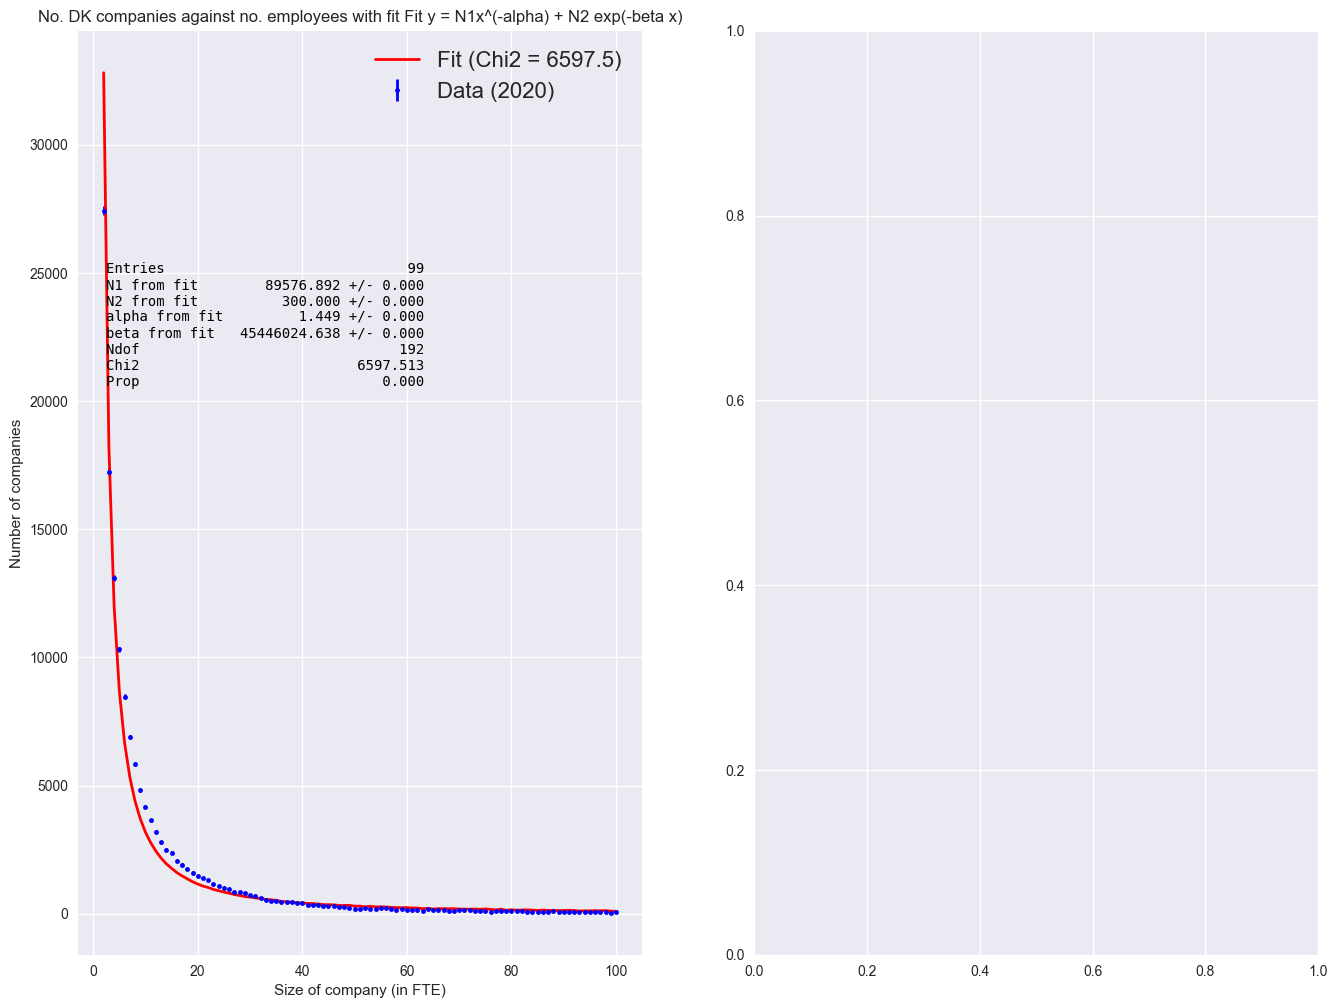

In [263]:
print("\n  ------------------------------------  Fitting Stage  --------------------------------------- \n")

minFit = 1
maxFit = 100

# Plot data points again
fig_fit, ax_fit = plt.subplots(nrows = 1, ncols = 2, figsize=(16, 12))
ax_fit = ax_fit.flatten()
 
fit_func_list = [pol1]
names = ['Fit y = N1x^(-alpha) + N2 exp(-beta x)','Fit N1 exp(-alpha x) + N2 exp(-beta x)',
        'Fit y = N1 x ^(-alpha) + N2 x ^(-beta)', 'Fit y = N1 exp(-alpha x^2) + N2 exp(-beta x)']

for i, func in enumerate(fit_func_list):

    ax_fit[i].errorbar(Nworkers[minPlot:maxPlot], Ncompanies[minPlot:maxPlot], yerr=eNcompanies[minPlot:maxPlot], fmt='.', linewidth=2,
                    color="blue", label='Data (2020)')
    ax_fit[i].set(xlabel="Size of company (in FTE)", ylabel="Number of companies", 
    title=f'No. DK companies against no. employees with fit {names[i]}')

# Power Law fit:
# --------------
    if 0:
        def ChiSquarePowerLaw(N, alpha):
            Ncompanies_est = func_PowerLaw(Nworkers[minFit:maxFit], N, alpha)
            chi2 = np.sum(((Ncompanies[minFit:maxFit] - Ncompanies_est) / eNcompanies[minFit:maxFit]) ** 2)
            return chi2

    chi2_object = Chi2Regression(func, Nworkers[minFit:maxFit], Ncompanies[minFit:maxFit], eNcompanies[minFit:maxFit])

    minuit = Minuit(chi2_object, N1=20000.0, N2 = 300.0, N3 = 10, N4 = 10, N5 = 10,  alpha=2.0, beta = 3.0)
    minuit.errordef = 1.0   # Chi2 fit
    minuit.migrad();
    if (not minuit.fmin.is_valid): 
        print("  WARNING: The ChiSquare fit DID NOT converge!!! ")

    for name in minuit.parameters:
        pass
    #    print("Fit value (exp): {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
    chi2 = minuit.fmin.fval
    Ndof = len(Ncompanies) - len(minuit.values[:])
    Prob = stats.chi2.sf(chi2, Ndof)
    #print(f"  Model fit:  Prob(Chi2={chi2:6.1f}, Ndof={Ndof:3d}) = {Prob:7.5f}")

    N1_fit, N2_fit, N3_fit, N4_fit, N5_fit, alpha_fit, beta_fit = minuit.values[:]
    eN1_fit, eN2_fit, eN3_fit, eN4_fit, eN5_fit, ealpha_fit, ebeta_fit = minuit.errors[:]

    ax_fit[i].plot(Nworkers[minFit:maxFit], func(Nworkers[minFit:maxFit], *minuit.values[:]), 
                'red', linewidth=2.0, label=f'Fit (Chi2 = {chi2:6.1f})')

    d = {'Entries': len(Ncompanies[minFit:maxFit]), 'N1 from fit': [minuit.values['N1'], minuit.errors['N1']],
        'N2 from fit': [minuit.values['N2'], minuit.errors['N2']], 
        'alpha from fit': [minuit.values['alpha'], minuit.errors['alpha']], 
        'beta from fit': [minuit.values['beta'], minuit.errors['beta']],'Ndof': Ndof, 'Chi2': chi2, 'Prop': Prob}
    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.05, 0.75, text, ax_fit[i], fontsize=10)
    ax_fit[i].legend(fontsize=16);

    # estimate no. of companies with 101-150 employees
    err = np.sqrt(np.sum(eNcompanies[101:150] ** 2))
    print('Actual no. companies with 101-150 employess: ', np.sum(Ncompanies[101:150]), " \u00B1", err)
    value_est = np.sum(func(Nworkers[101:150], *minuit.values[:]))
    
    print(f'Est no. companies for names{i}: ', value_est )



# Questions

1. Try to fit the data (in the range 1-100) with a power law, an exponential, and a combination of the two. Are you satisfied with the results? Perhaps include a new plot of the residuals (i.e. data - fit) below the one showing the fit itself.
2. Can you think of any other function that would fit throught the data better? Try to expand on the functions by adding more complexity and parameters, and see how well you can do. Do you manage to reach a "good" model, and how would you define one such?
3. From a "good" fit, try to predict how many companies there are with 101-150 employes. Compare this number to the data, and see how well you manage.

In [ ]:
if (save_plots):
    plt.savefig("fig_NworkersInDKcompanies_Fit.pdf")

# Learning points:

From this exercise you should become capable of fitting data (in histogram) with many different (possibly similar) models, and evaluate their performance. From the last question, you should also become capable of extrapolating to obtain an estimate of the number of larger companies.